# Introduction to Time Dependent Circuits

Before starting this tutorial, you should be comfortable with using the loop rule and the junction rule in DC circuits, as well as the concepts of the resistor, the capacitor, and the inductor.  If you haven't seen RC and LR circuits before, you may want to read the relevant OpenStax texts where they are linked.

Our starting point will be a series RC circuit:

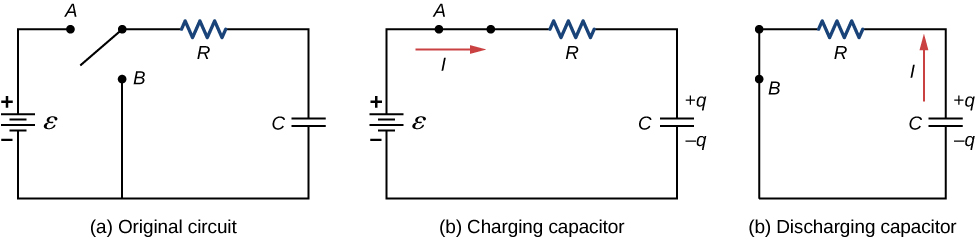

Figure  10.6.1 : (a) An $RC$ circuit with a two-pole switch that can be used to charge and discharge a capacitor. (b) When the switch is moved to position $A$, the circuit reduces to a simple series connection of the voltage source, the resistor, the capacitor, and the switch. (c) When the switch is moved to position $B$, the circuit reduces to a simple series connection of the resistor, the capacitor, and the switch. The voltage source is removed from the circuit.

(Figure licensed under [CC4.0](https://creativecommons.org/licenses/by/4.0/) from Ling, Sanny, & Moebs, [OpenStax University Physics, Section 10.6](https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_University_Physics_(OpenStax)/Map%3A_University_Physics_II_-_Thermodynamics%2C_Electricity%2C_and_Magnetism_(OpenStax)/10%3A_Direct-Current_Circuits/10.06%3A_RC_Circuits); retrieved 27 June, 2020)

Let's say that we want to predict the voltage across the capacitor as a function of time.  Write down the loop rule for the circuit in configuration (b):

$$\mathcal{E} - IR - \frac{Q}{C} = 0$$

$\mathcal{E}$, $R$, and $C$ are fixed, but both $I$ and $Q$ change with time.  They are related, since the current is the time rate of change of the charge on the capacitor.  This means we can write down a _differential equation_ that involves only $Q$ and its time derivative(s):

$$\mathcal{E} - \frac{dQ}{dt}R - \frac{Q}{C} = 0 \;\;\;\to\;\;\; \frac{dQ}{dt} = \frac{\mathcal{E}}{R} - \frac{Q}{RC} \;\;\;(1)$$

Whether you have studied differential equations or not, you can solve them numerically.  We will be approaching many time-dependent circuits as _initial value problems_.  This means that we want to find the time-dependent behavior of a variable given the value of the variable at the point we call $t=0$.  We can use that initial value to find the initial rate of change, then use that and a small $\Delta t$ to advance the value of the variable in time.  

We're going to use a package called `scipy.integrate` which provides many options for numerical integration.  To start off with, we'll use a routine called `solve_ivp`, since it does exactly what we need ("`ivp`" stands for "initial value problem").  There are *many* details under the hood, including a choice of various algorithms for advancing the solution through time, but we need not concern ourselves with this just yet.  Suffice it to say at the moment that it takes the initial conditions you provide and steps carefully forward in time by going back and forth between calculating $dQ/dt$ and $Q$.  

Below is an example of how to solve Equation 1 using `solve_ivp`.  To start, we need to import the packages we will use and define quantities that we would control when we build the circuit (component values, etc.):

In [2]:
#import modules that we will use
import numpy as np #routines that let us use multi-dimensional arrays
from matplotlib import cm #colormap module for customization
import matplotlib.pyplot as plt #plotting routines
from scipy.integrate import solve_ivp #solve initial value problem/differential equation


# Define fixed quantities
# I'll choose some reasonable values that you could find in the lab that give a timescale we could observe.
V_bat = 5.0 # Ideal battery provides a constant voltage
R = 1e5 #Ohms
C = 1e-6 #F

To use `solve_ivp`, we need to define the derivative in terms of everything else, which we've already done in Equation 1.  Therefore, we write a function that returns the derivative in terms of our other parameters.  The solver specifies a format, so we just follow it according to the documentation.  Any parameters besides our $y$ variable and time come after those.

In [3]:
# write a function to return dy/dt in terms of y
# the form is given by the solve_ivp documentation

# we'll name it according to what it is -- the terms that represent dQ/dt for circuit (b)
def dQdt_b(t, Q, V_bat, R, C):
    # all we need to do is return the right hand side of Eq. 1
    return V_bat/R - Q/(R*C)

Now we need to choose initial conditions and how much time we are going to simulate.  Since $\tau = RC = 0.1$ s with the parameters we've chosen, we should simulate about ten times that.  For convenience, let's leave the initial time at zero and simulate the interval `[0,1]`.

Text(0, 0.5, 'Capacitor Voltage (V)')

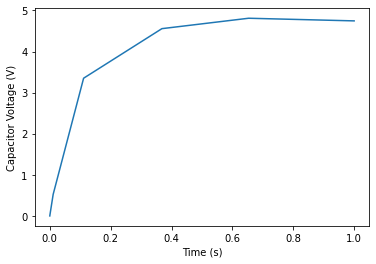

In [47]:
sol = solve_ivp(dQdt_b, [0,1], [0.0,], args=(V_bat,R,C))

# plot the solution as a function of time
# instead of plotting the charge, let's plot the voltage V = Q/C
plt.plot(sol.t,sol.y.squeeze()/C)  #calling the 'squeeze' method chops off an empty second dimension
plt.xlabel('Time (s)')
plt.ylabel('Capacitor Voltage (V)')

This is a bit coarse in terms of resolution, so let's specify a smaller time step.  A good rule of thumb is that you want a time step about ten times smaller than the smallest timescale you care about.  Here, that's $0.1$s, so we'll make $\Delta t = 0.01$s.  The easiest way to do that is to put a limit on the maximum time step the algorithm will take:

Text(0, 0.5, 'Capacitor Voltage (V)')

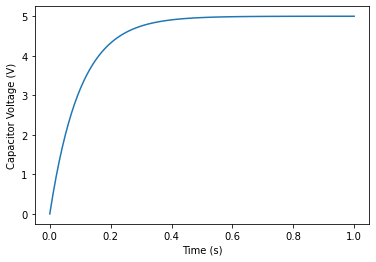

In [48]:
sol = solve_ivp(dQdt_b, [0,1], [0.0], max_step=1e-2, args=(V_bat,R,C))

# plot voltage vs time
plt.plot(sol.t,sol.y.squeeze()/C)
plt.xlabel('Time (s)')
plt.ylabel('Capacitor Voltage (V)')

Now, let's look at the circuit in part (c) of the figure.  Again, we need to write down the differential equation and define a function to pass to the integrator.  The difference now is that there is no battery.  This means that we can set the voltage of the battery to zero and recover the appropriate equation:
$$ - \frac{dQ}{dt}R - \frac{Q}{C} = 0 \;\;\;\to\;\;\; \frac{dQ}{dt} = - \frac{Q}{RC} \;\;\;(2)$$
We also need to choose an initial value for $Q$.  Since nothing would happen if $Q(t=0) = 0$ F, let's assume that we've just charged up the capacitor so that the initial charge is $Q(t=0) = C\mathcal{E}$.

Text(0, 0.5, 'Capacitor Voltage (V)')

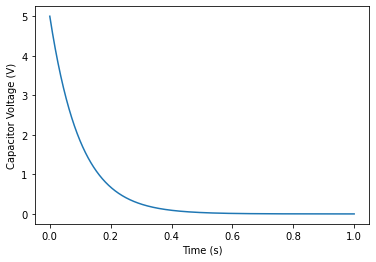

In [49]:
# new function for dy/dt in circuit (c)

def dQdt_c(t, Q, V_bat, R, C):
    return -Q/(R*C)

# initial condition
Q_0 = V_bat*C

# solve the new equation
sol = solve_ivp(dQdt_c, [0,1], [Q_0], max_step=1e-3, args=(V_bat,R,C))

# plot voltage vs time
plt.plot(sol.t,sol.y.squeeze()/C)
plt.xlabel('Time (s)')
plt.ylabel('Capacitor Voltage (V)')


Here's one last trick.  Let's imagine flipping the switch from circuit (b) to circuit(c) at $t=1$ s.  In order to simulate this, all we have to do is change the circuit equation at the appropriate time.

Text(0, 0.5, 'Capacitor Voltage (V)')

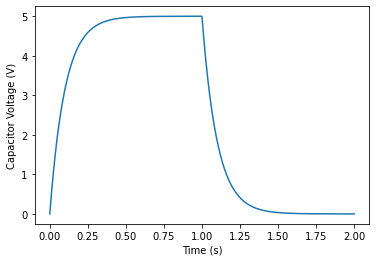

In [50]:
# write a function to return dy/dt in terms of y
# the form is given by the solve_ivp documentation
def dQdt_bc(t, Q, V_bat, R, C):

    if t< 1:
        #for the first second, we have the equation for (b)
        return V_bat/R - Q/(R*C)
    else:
        #after that, we have the equation for (c)
        return -Q/(R*C)

# we start with no charge on the capacitor again, so  Q_0 = 0.0
# now we'll want to simulate for at least two seconds, so our time interval needs to be [0,2]
sol = solve_ivp(dQdt_bc, [0,2], [0.0], max_step=1e-3, args=(V_bat,R,C))

# plot voltage vs time
plt.plot(sol.t,sol.y.squeeze()/C)
plt.xlabel('Time (s)')
plt.ylabel('Capacitor Voltage (V)')

At time zero, you close the switch to position $A$ and it charges.  Then at $t=1$s, you move the switch to position $B$ and it discharges.  Both pieces of the curve are exponential functions with a timescale of $\tau = RC$.

Play around with the parameters in the above code and see what happens. Then, it will be your turn to simulate the LR circuit.

# The Series LR Circuit

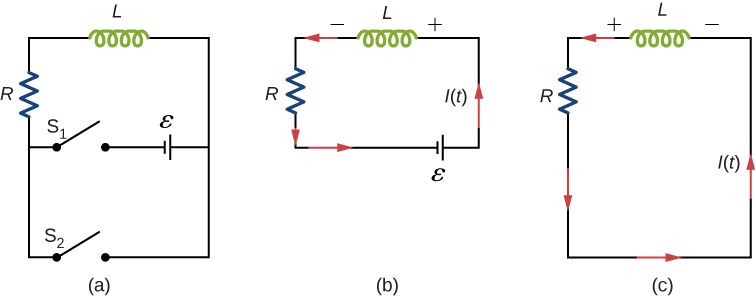
Figure  14.5.1 : (a) An $RL$ circuit with switches  $S_1$  and  $S_2$ . (b) The equivalent circuit with  $S_1$  closed and  $S_2$  open. (c) The equivalent circuit after  $S_1$  is opened and  $S_2$  is closed.

(Figure licensed under [CC4.0](https://creativecommons.org/licenses/by/4.0/) from Ling, Sanny, & Moebs, [OpenStax University Physics, Section 14.5](https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_University_Physics_(OpenStax)/Map%3A_University_Physics_II_-_Thermodynamics%2C_Electricity%2C_and_Magnetism_(OpenStax)/14%3A_Inductance/14.05%3A_RL_Circuits); retrieved 27 June, 2020)

There are two major differences in the equations you will set up:
* This time, we don't need to keep track of the charge but rather the current.  The voltage across the resistor is proportional to the current and the voltage across the inductor is proportional to $dI/dt$, so our differential equation is one for $I$.
* The initial condition is different because you are thinking about the current.  Keep in mind that the current cannot change instantaneously through the inductor when you close or open a switch, so the initial value of the current in the inductor must be the same as it was before the switch was moved.

### Your tasks are:
* Write down the equations for each of the switch positions using the loop rule.  Put them in the same form as before, with the derivative by itself on the left-hand side.
* Modify the functions we defined for the RC circuit so that they will return the right-hand side of the equations you've just constructed.
* Imagine that the resistance in the circuit is actually just the resistance of the wire that the inductor is made out of.  Take $R = 0.001\,\Omega$ as a reasonable value.  Then choose $L$ such that the relevant time scale for this circuit is $L/R = 0.1$s.
* Simulate closing $S_1$ at $t=0$s, then opening $S_1$ and closing $S_2$ at $t=1$s and plot the current across the inductor as a function of time.
* (optional challenge) Plot the _voltage_ across the inductor as a function of time.